# Lab 1 Task 2

In [1]:
!pip install thop
!pip install torchsummary

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary
# Enable cuDNN benchmark for faster convolutions on constant input sizes
torch.backends.cudnn.benchmark = True

In [11]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [18]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.49140224 0.4821559  0.4465299 ] [0.24703225 0.24348493 0.2615876 ]
[0.49140224 0.4821559  0.4465299 ] [0.24703225 0.24348493 0.2615876 ]


In [ ]:
##### data augmentation & normalization #####
# 使用 CIFAR-10 標準均值和標準差
CIFAR10_MEAN = train_mean.tolist()
CIFAR10_STD = train_std.tolist()

transform_train = transforms.Compose([
    # 同學實作部分：Add data augmentation here
    # 數據增強策略
    transforms.RandomHorizontalFlip(p=0.5),  # 隨機水平翻轉
    transforms.RandomRotation(degrees=15),   # 隨機旋轉角度
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # 隨機調整亮度、對比、飽和度、色調
    transforms.RandomCrop(32, padding=4),    # 隨機裁切，並加上填充
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 隨機平移
    transforms.ToTensor(),                   # 轉成 tensor
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),  # 標準化
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # 隨機遮蔽
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
])

In [ ]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
# 批次大小設定
BATCH_SIZE = 256 # 根據硬體資源調整
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection
        
        # 第一個卷積層
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 第二個卷積層
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 殘差連接
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        
        # 主路徑
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # 殘差連接
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 學生實作部分：Define the ResNet-18 architecture using BasicBlock
        
        self.in_channels = 64
        
        # 初始層，適合 32x32 圖像
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 四個殘差層
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # 全局平均池化和分類器
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # 權重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        """權重初始化"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 學生實作部分：Define make_layer function to create layers of blocks
        
        layers = []
        in_channels = self.in_channels
        
        # 第一個block
        layers.append(block(in_channels, out_channels, stride))
        
        # 更新輸入通道數
        self.in_channels = out_channels
        
        # 其餘block
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # 學生實作部分：Define the forward pass of ResNet-18
        
        # 前向傳播
        x = F.relu(self.bn1(self.conv1(x)))
        
        # 四個殘差層
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 全局平均池化和分類
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        
        return out

In [ ]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

model = ResNet18(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print model summary
summary(model, (3, 32, 32))

# Calculate FLOPs and Params
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Setting parameter
# 優化訓練參數
EPOCH = 100       
pre_epoch = 0     
lr = 0.1          # 學習率（使用SGD的標準學習率）

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
# 使用比較適合 CIFAR-10 的優化器和損失函數
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 添加 Label Smoothing 正則化
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)  # SGD + 動量 + 權重衰減

# 添加學習率調度器（Warmup + Cosine Annealing）
import math
def lr_lambda(epoch):
    if epoch < 5:  # Warmup 階段：前5個epoch線性增加學習率
        return epoch / 5
    else:  # Cosine Annealing：餘下epoch使用餘弦退火
        return 0.5 * (1 + math.cos(math.pi * (epoch - 5) / (EPOCH - 5)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

best_model_path = 'best_resnet18.pth'

# 添加混合精度訓練和早停機制
from torch.cuda.amp import GradScaler, autocast

# 混合精度縮放器
scaler = GradScaler()
# 早停機制
patience = 30
patience_counter = 0

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # 學生實作部分：Complete the training and validation loop  
    # ========== 訓練階段 ==========
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 梯度歸零
        optimizer.zero_grad()
        
        # 混合精度前向傳播
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        # 混合精度反向傳播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # 統計訓練指標
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    # 計算訓練準確率
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    
    # ========== 驗證階段 ==========
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # 驗證時不需要計算梯度
        for inputs, targets in valloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 混合精度驗證
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # 統計驗證指標
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    # 計算驗證準確率
    val_loss = val_loss / len(valloader)
    val_acc = 100. * val_correct / val_total
    
    # 更新學習率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 記錄訓練指標
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # 早停機制
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    
    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"   Best validation accuracy: {best_val_acc:.2f}%")
        break


    # 添加學習率顯示
    print(f"Epoch [{epoch+1:3d}/{EPOCH}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.6f}")


/tmp/ipykernel_14824/1171999296.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


/tmp/ipykernel_14824/1171999296.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_14824/1171999296.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [  1/100] Train Loss: 2.3564 | Train Acc: 10.08% | Val Loss: 2.3531 | Val Acc: 10.46% | LR: 0.020000
Epoch [  2/100] Train Loss: 2.1166 | Train Acc: 26.46% | Val Loss: 1.8672 | Val Acc: 33.92% | LR: 0.040000
Epoch [  3/100] Train Loss: 1.7991 | Train Acc: 39.05% | Val Loss: 1.8455 | Val Acc: 39.28% | LR: 0.060000
Epoch [  4/100] Train Loss: 1.6304 | Train Acc: 47.86% | Val Loss: 1.6513 | Val Acc: 47.18% | LR: 0.080000
Epoch [  5/100] Train Loss: 1.4899 | Train Acc: 55.01% | Val Loss: 1.6051 | Val Acc: 51.58% | LR: 0.100000
Epoch [  6/100] Train Loss: 1.3634 | Train Acc: 61.26% | Val Loss: 1.5636 | Val Acc: 53.48% | LR: 0.099973
Epoch [  7/100] Train Loss: 1.2642 | Train Acc: 65.89% | Val Loss: 1.3038 | Val Acc: 63.94% | LR: 0.099891
Epoch [  8/100] Train Loss: 1.1991 | Train Acc: 69.24% | Val Loss: 1.3359 | Val Acc: 63.84% | LR: 0.099754
Epoch [  9/100] Train Loss: 1.1441 | Train Acc: 71.57% | Val Loss: 1.2165 | Val Acc: 68.86% | LR: 0.099563
Epoch [ 10/100] Train Loss: 1.1103 | 

In [26]:
# Load the best model and evaluate on the test set
# Ensure to load the best checkpoint before testing
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best checkpoint test accuracy: {test_accuracy:.2f}%")

/tmp/ipykernel_14824/1175938196.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Best checkpoint test accuracy: 94.83%


/home/twccjq88/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Training summary (optimized version):
   Best validation accuracy: 91.78%
   Final training accuracy: 97.83%
   Final validation accuracy: 91.00%
   Total epochs: 100
   Baseline accuracy: 83.98%
   Accuracy improvement: 7.80%


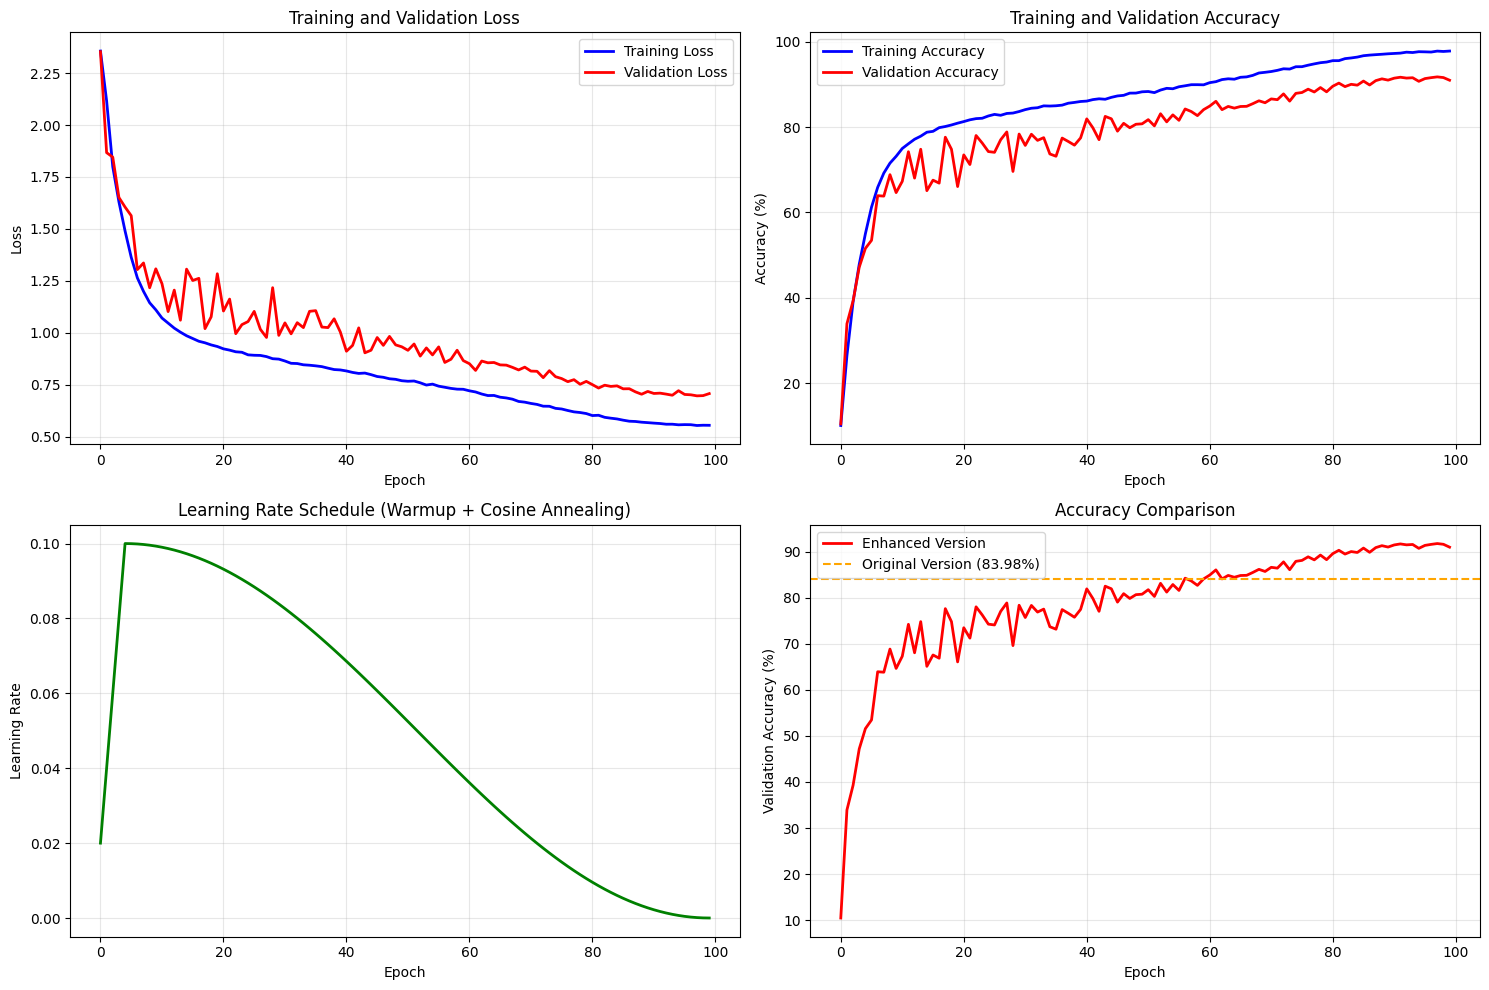

In [ ]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
# 學生實作部分：Plot training and validation loss and accuracy curves

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 繪製損失曲線
ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 繪製準確率曲線
ax2.plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Modification: Learning rate curve
epochs_range = range(len(train_losses))
lr_values = []
# Recompute LR schedule independently to plot
temp_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
temp_scheduler = optim.lr_scheduler.LambdaLR(temp_optimizer, lr_lambda)
for epoch in epochs_range:
    temp_scheduler.step()
    lr_values.append(temp_optimizer.param_groups[0]['lr'])

ax3.plot(epochs_range, lr_values, color='green', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule (Warmup + Cosine Annealing)')
ax3.grid(True, alpha=0.3)

# 添加準確率提升對比
ax4.plot(val_accuracies, label='Enhanced Version', color='red', linewidth=2)
ax4.axhline(y=83.98, color='orange', linestyle='--', label='Original Version (83.98%)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Validation Accuracy (%)')
ax4.set_title('Accuracy Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 調整佈局
plt.tight_layout()

# Print training summary (English)
print("Training summary (optimized version):")
print(f"   Best validation accuracy: {max(val_accuracies):.2f}%")
print(f"   Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"   Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Baseline accuracy: 83.98%")
print(f"   Accuracy improvement: {max(val_accuracies) - 83.98:.2f}%")

plt.show()